## Exploratory Data Analysis of Canadian Bill Data (1994 - 2022)

In [499]:
# Import Python libraries
import pandas as pd
import numpy as np
import plotly.express as px

In [500]:
# Read aggregated datasets
data = pd.read_csv('../data/cleaned/bill_data.csv')
parliaments = pd.read_csv('../data/cleaned/parliament_data.csv')

# Change parliaments columns back to datetime format
for col in ['StartDate', 'EndDate']:
    parliaments[col] = pd.to_datetime(parliaments[col])

parliaments['Duration'] = pd.to_timedelta(parliaments['Duration'])

# Display all columns
with pd.option_context('display.max_columns', None): 
    display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days


Visualization Ideas:
1. Number of bills in each parliament (do parliaments have consistent length?)
2. Number and percentage of bills by type
3. Number of bills that made it to each stage (bar chart)
4. Mean, median, and outliers of the time spent debating (amongst bills that received royal assent)
5. Number of bills sponsored by political affiliation (take a subset of years as well, compare Harper and Trudeau eras)
6. Group the bills by title if possible

Out of Curiosity:
- Which person sponsored the greatest number of bills, also sort by role (Senator, MP, other?)
- Which constituency sponsored the greatest number of bills

### Part 1: Bills by Parliament Number

In [501]:
# Number of bills in each parliament
plot_1 = data[[
    'ParliamentNumber',
    'SessionNumber',
    'ReceivedRoyalAssent', 
    'ReadingsPassed'
]].groupby([
    'ParliamentNumber',
    'SessionNumber'
])

plot_1 = pd.concat([
    plot_1.sum(), 
    plot_1.size()], 
    axis = 1
)

plot_1.rename(columns = {
    'ReceivedRoyalAssent': 'BillsPassed',
    'ReadingsPassed': 'TotalReadingsPassed',
    0: 'UniqueBills'
}, inplace = True)

plot_1.reset_index(inplace = True)

display(plot_1.head(4))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills
0,35,1,101,845,300
1,35,2,69,755,358
2,36,1,86,907,438
3,36,2,38,625,390


In [502]:
# Merge with parliament data
plot_1 = pd.merge(plot_1, parliaments, on = ['ParliamentNumber', 'SessionNumber'], how = 'left')
display(plot_1.head(4))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings
0,35,1,101,845,300,Liberal Party,Jean Chrétien,False,1994-01-17,1996-02-02,746 days,133.0,278
1,35,2,69,755,358,Liberal Party,Jean Chrétien,False,1996-02-27,1997-04-27,425 days,96.0,164
2,36,1,86,907,438,Liberal Party,Jean Chrétien,False,1997-09-22,1999-09-18,726 days,158.0,243
3,36,2,38,625,390,Liberal Party,Jean Chrétien,False,1999-10-12,2000-10-22,376 days,84.0,133


In [503]:
# Create readings per day and bills per day columns
plot_1['ReadingsPerDay'] = plot_1['TotalReadingsPassed'] / plot_1['Duration'].dt.days
plot_1['BillsPerDay'] = plot_1['BillsPassed'] / plot_1['Duration'].dt.days

display(plot_1.head(3))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay
0,35,1,101,845,300,Liberal Party,Jean Chrétien,False,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389
1,35,2,69,755,358,Liberal Party,Jean Chrétien,False,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353
2,36,1,86,907,438,Liberal Party,Jean Chrétien,False,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457


In [504]:
# Removing sessions lasting less than 150 days due to the unstable nature of these parliaments

plot_1 = plot_1.loc[plot_1['Duration'].dt.days > 150, :]

# Create new column that aggregates party and minority status

plot_1['Party'] = plot_1['Party'].apply(lambda x: x.split(' ', 1)[0])
plot_1['Minority'] = plot_1['Minority'].apply(lambda x: 'Minority' if x == True else 'Majority')
plot_1['Government'] = plot_1['Party'] + ' ' + plot_1['Minority']

# Create middle date column

plot_1['StartYear'] = pd.DatetimeIndex(plot_1['StartDate']).year.astype(str)
plot_1 = plot_1.reset_index()

display(plot_1.head(3))

,index,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay,Government,StartYear
0,0,35,1,101,845,300,Liberal,Jean Chrétien,Majority,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389,Liberal Majority,1994
1,1,35,2,69,755,358,Liberal,Jean Chrétien,Majority,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353,Liberal Majority,1996
2,2,36,1,86,907,438,Liberal,Jean Chrétien,Majority,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457,Liberal Majority,1997


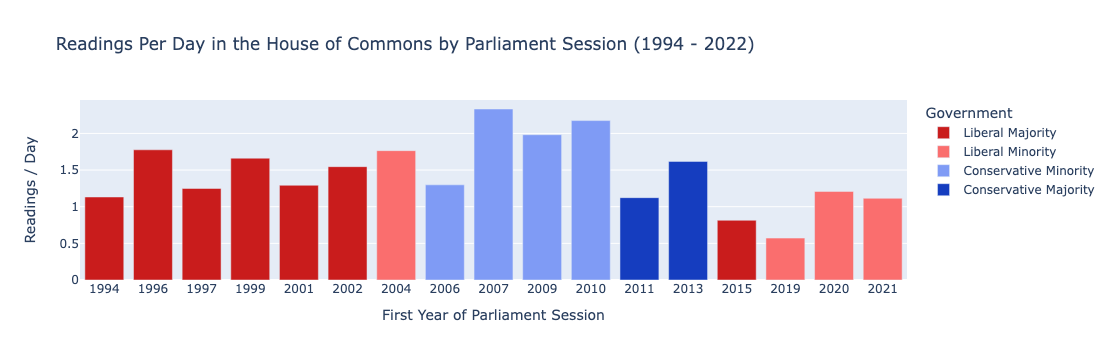

In [505]:
color_map =  { 
    "Liberal Majority": "#c91c1c", 
    "Liberal Minority": "#fa6e6e",
    "Conservative Minority": "#7f9bf5",
    "Conservative Majority": "#153dbf"
}

fig = px.bar(
    plot_1, 
    x = "StartYear", 
    y = "ReadingsPerDay", 
    color= "Government",
    color_discrete_map = color_map,
    title = "Readings Per Day in the House of Commons by Parliament Session (1994 - 2022)",
    labels = {
        "StartYear": "First Year of Parliament Session",
        "ReadingsPerDay": "Readings / Day"
    }
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

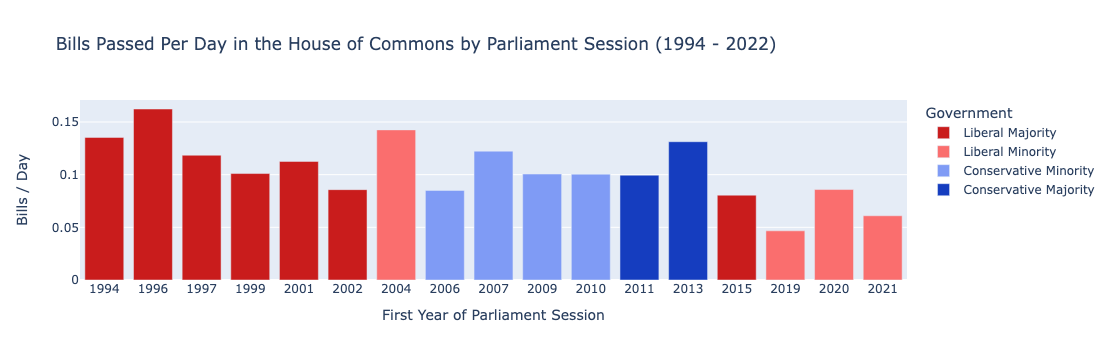

In [506]:
fig = px.bar(
    plot_1, 
    x = "StartYear", 
    y = "BillsPerDay", 
    color="Government",
    color_discrete_map = color_map,
    title = "Bills Passed Per Day in the House of Commons by Parliament Session (1994 - 2022)",
    labels = {
        "StartYear": "First Year of Parliament Session",
        "BillsPerDay": "Bills / Day"
    }
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

### Part 2: Bills By Type and Origin

In [507]:
plot_2 = pd.DataFrame(data['BillType'].value_counts())
plot_2.reset_index(inplace = True)

plot_2.rename(
    columns = {
        "index": "Bill Type",
        "BillType": "Count"
    }, 
    inplace = True
)

def getOrigin(x):
    x = x.split(' ')[0]
    return x

plot_2["Origin"] = plot_2["Bill Type"].apply(lambda x: getOrigin(x))

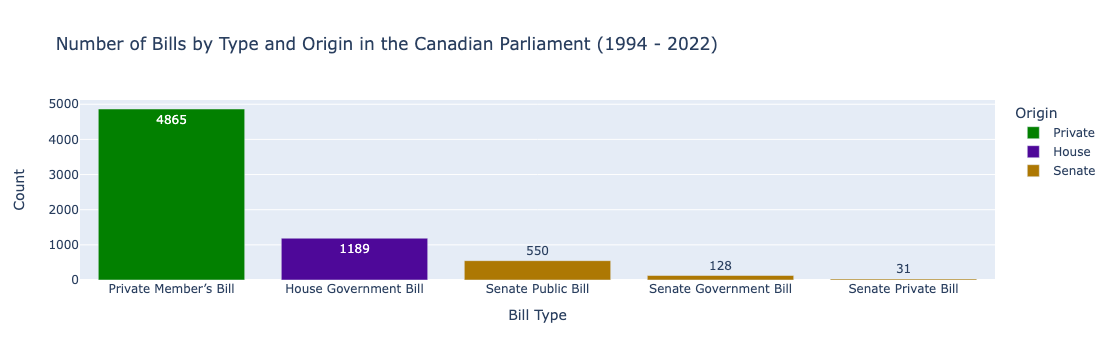

In [508]:
color_map = {
    "Private": "#028000",
    "House": "#4e0899",
    "Senate": "#ad7803"
}

fig = px.bar(
    plot_2, 
    x = "Bill Type",
    y = "Count",
    text = "Count",
    color = "Origin",
    color_discrete_map = color_map,
    title = "Number of Bills by Type and Origin in the Canadian Parliament (1994 - 2022)"
)

fig.show()

### Part 3: Bills by Stage

In [509]:
display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days


In [510]:
# Get data and group by 'ReadingsPassed'
plot_3 = data[['ReadingsPassed']].groupby('ReadingsPassed')

# Count the number of entries in each category of 'ReadingsPassed'
plot_3 = pd.concat(
    [plot_3.value_counts()],
    axis = 1
)

plot_3.reset_index(inplace = True)

# Rename columsn for clarity
plot_3 = plot_3.rename(columns = {
    'ReadingsPassed': 'Reading',
    0: 'Failed'
})

# Get the number of bills that have received royal assent from the original dataframe
assent = data.ReceivedRoyalAssent.sum()

# Include royal assent data in the dataframe
failed = list(plot_3['Failed'])
failed[5] = 995 - assent

# Create new column that contains the number of bills that passed the stage
passed = list()
remaining = 6763
for num in failed:
    passed.append(remaining - num)
    remaining -= num

# Update the dataframe with new information
plot_3['Failed'] = failed
plot_3['Passed'] = passed
plot_3['Stage'] = [
    '1st Reading',
    '2nd Reading',
    '3rd Reading',
    '4th Reading',
    '5th Reading',
    '6th Reading'
]

# Append the Royal Assent row to the dataframe
plot_3 = pd.concat([
    plot_3,
    pd.DataFrame({
        'Reading': 'N/A', 
        'Failed': 0,
        'Passed': assent,
        'Stage': 'Royal Assent'
    }, index = [6])
])

# Display the dataset
display(plot_3)

,Reading,Failed,Passed,Stage
0,1,5085,1678,1st Reading
1,2,467,1211,2nd Reading
2,3,24,1187,3rd Reading
3,4,100,1087,4th Reading
4,5,92,995,5th Reading
5,6,11,984,6th Reading
6,N/A,0,984,Royal Assent


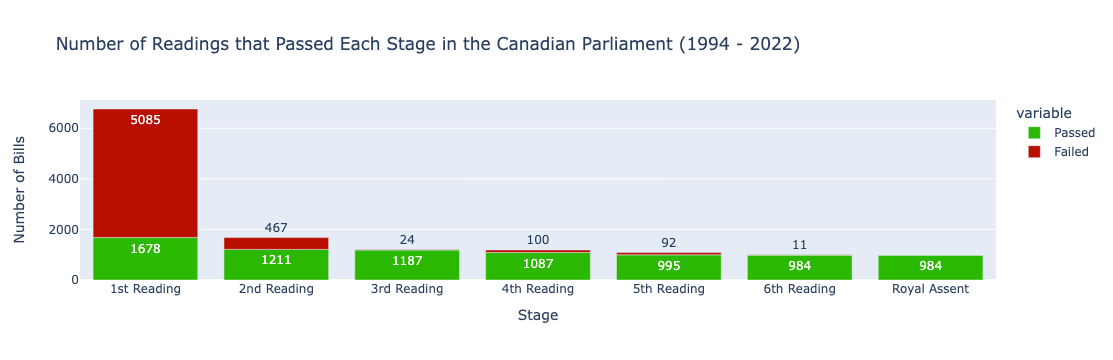

In [511]:
color_map = {
    "Passed": "#2bb800",
    "Failed": "#b80f00",
}


fig = px.bar(
    plot_3, 
    x = "Stage", 
    y = ["Passed", "Failed"], 
    title = "Number of Readings that Passed Each Stage in the Canadian Parliament (1994 - 2022)",
    color_discrete_map = color_map,
    text_auto = True,
    labels = {
        "value": "Number of Bills",
        "Reading": "Stage"
    }
)

fig.show()

### Part 4: Time Spent Debating (For Passing Bills)

In [512]:
# Get all bills that received Royal Assent
plot_4 = data.loc[
    data['ReceivedRoyalAssent'] == True, 
    ['TimeAlive', 'Title', 'Id', 'ParliamentNumber']
]

plot_4.reset_index(inplace = True)

# Convert TimeAlive to an integer
plot_4['TimeAlive'] = plot_4['TimeAlive'].apply(lambda x: x.split(' ')[0]).astype(int)

# Get party data
party = parliaments[['ParliamentNumber', 'Party', 'PrimeMinister']]

# Concatenate plot_4 with party data to get Prime Minister and Party
plot_4 = pd.merge(plot_4, party, on = ['ParliamentNumber'], how = 'left')
plot_4 = plot_4.drop_duplicates()

# Display DataFrame
display(plot_4.head())

,index,TimeAlive,Title,Id,ParliamentNumber,Party,PrimeMinister
0,19,659,Strengthening Motor Vehicle Safety for Canadia...,42-1/S-2,42,Liberal Party,Justin Trudeau
1,20,605,Incorporation by Reference in Regulations Act,41-2/S-2,41,Conservative Party,Stephen Harper
3,21,630,Family Homes on Reserves and Matrimonial Inter...,41-1/S-2,41,Conservative Party,Stephen Harper
5,22,273,Protecting Victims From Sex Offenders Act,40-3/S-2,40,Conservative Party,Stephen Harper
8,23,134,An Act to amend the Customs Act,40-2/S-2,40,Conservative Party,Stephen Harper


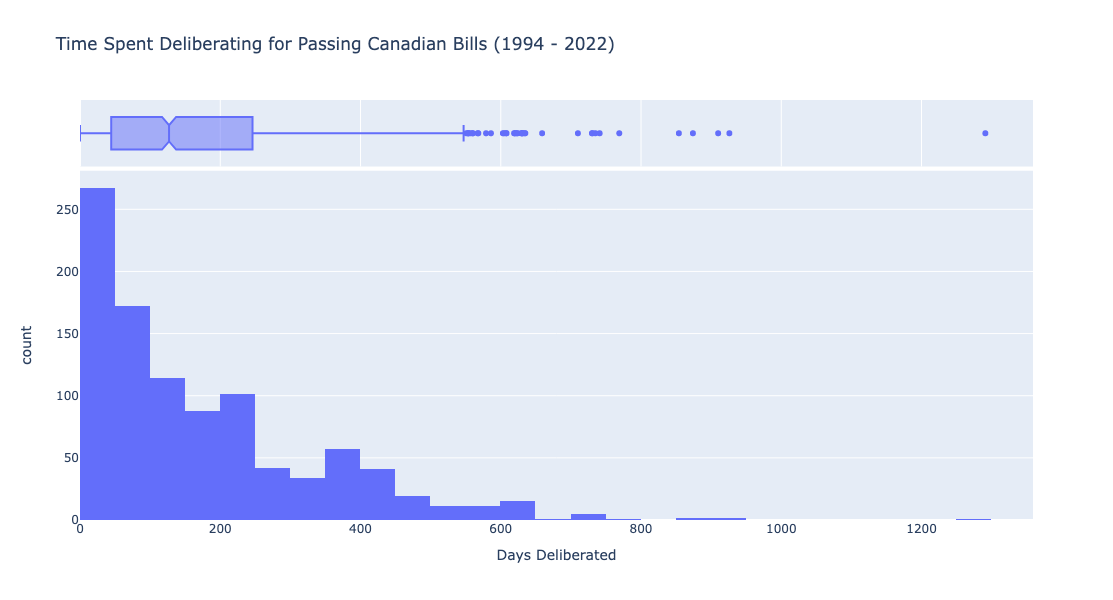

In [513]:
fig = px.histogram(
    plot_4, 
    x = "TimeAlive",
    nbins = 30,
    marginal = "box",
    title = "Time Spent Deliberating for Passing Canadian Bills (1994 - 2022)",
    labels = {
        "count": "Count",
        "TimeAlive": "Days Deliberated"
    },
    height = 600
)

fig.update_xaxes(rangemode = "nonnegative")

fig.show()

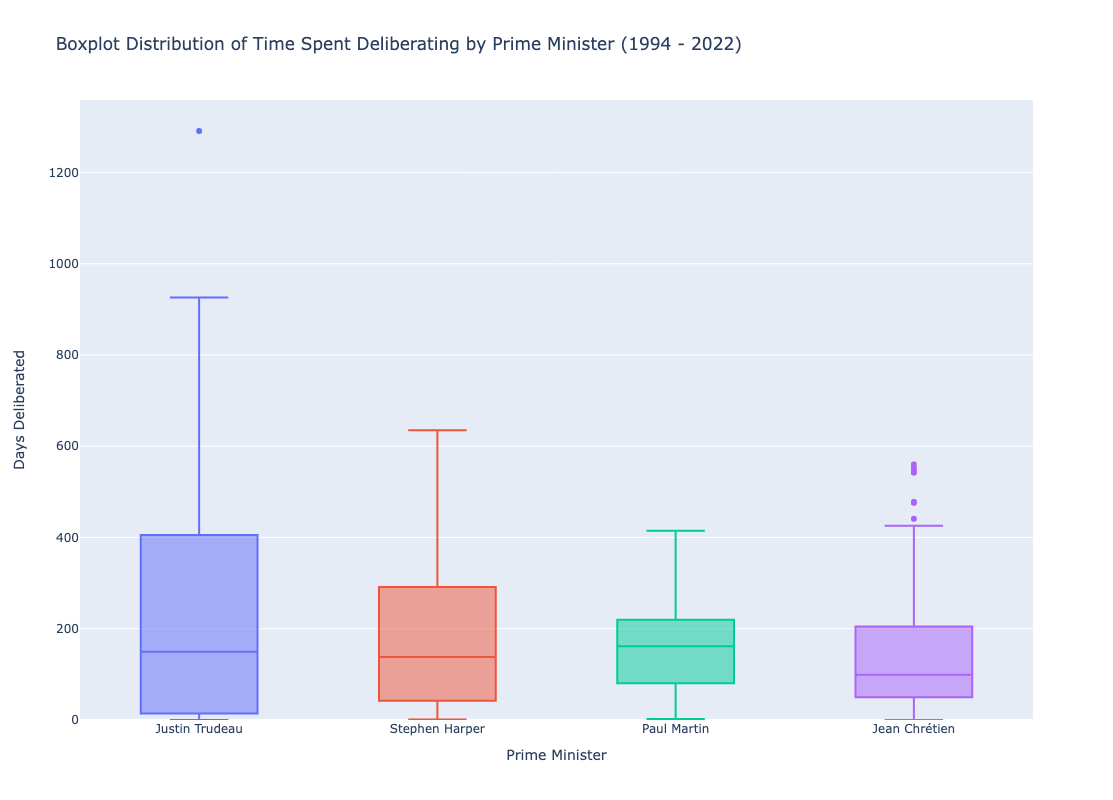

In [514]:
fig = px.box(
    plot_4,
    x = 'PrimeMinister',
    y = 'TimeAlive',
    color = 'PrimeMinister',
    points = 'outliers',
    title = "Boxplot Distribution of Time Spent Deliberating by Prime Minister (1994 - 2022)",
    labels = {
        'TimeAlive': 'Days Deliberated',
        'PrimeMinister': 'Prime Minister'
    },
    height=800
)

fig.update_layout(
    showlegend = False
)

fig.update_yaxes(rangemode = "nonnegative")
fig.show()

In [515]:
# Bills
display(plot_4.loc[plot_4['TimeAlive'] > 800, ['Id', 'TimeAlive', 'Title', 'PrimeMinister']])

,Id,TimeAlive,Title,PrimeMinister
216,42-1/S-203,1291,Ending the Captivity of Whales and Dolphins Act,Justin Trudeau
227,42-1/S-210,926,An Act to amend An Act to amend the Immigratio...,Justin Trudeau
243,42-1/S-218,854,Latin American Heritage Month Act,Justin Trudeau
808,42-1/C-21,910,An Act to amend the Customs Act,Justin Trudeau
1804,42-1/C-211,874,Federal Framework on Post-Traumatic Stress Dis...,Justin Trudeau


In [516]:
display(plot_4.loc[plot_4['TimeAlive'] == 0, ['Id', 'TimeAlive', 'Title', 'PrimeMinister']])

,Id,TimeAlive,Title,PrimeMinister
311,42-1/C-3,0,"Appropriation Act No. 4, 2015-16",Justin Trudeau
513,43-1/C-10,0,"Appropriation Act No. 4, 2019-20",Justin Trudeau
533,35-1/C-10,0,An Act to provide for the maintenance of west ...,Jean Chrétien
538,43-1/C-11,0,"Appropriation Act No. 1, 2020-21",Justin Trudeau
574,43-1/C-12,0,An Act to amend the Financial Administration A...,Justin Trudeau
632,43-1/C-14,0,"COVID-19 Emergency Response Act, No. 2",Justin Trudeau


### Part 5: Bills by Political Affiliation

In [517]:
display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days


In [546]:
plot_5 = data.loc[
    data['Political Affiliation'].notnull(), 
    ['Id', 'SponsorName', 'SponsorTitle', 'Title', 'Political Affiliation']
]

plot_5.rename(columns = {
    'Political Affiliation': 'Party'
}, inplace = True)

def fixParties(party):
    if party in ['Ind. CA', 'Independent Bloc Québécois', 'Independent Conservative', 'Conservative Independent']:
        return 'Independent'
    
    if party == 'PC':
        return 'Conservative'
    
    return party

plot_5['Party'] = plot_5['Party'].apply(lambda x: fixParties(x))

plot_5 = pd.DataFrame(plot_5['Party'].value_counts()).reset_index()

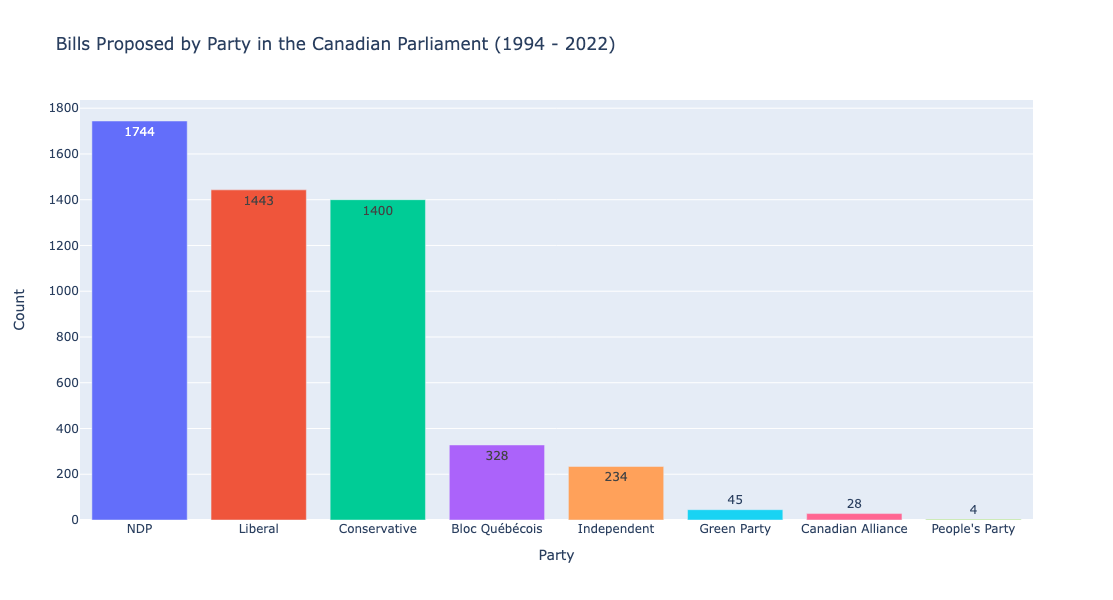

In [548]:
fig = px.bar(
    plot_5,
    x = 'index',
    y = 'Party',
    color = 'index',
    title = 'Bills Proposed by Party in the Canadian Parliament (1994 - 2022)',
    labels = {
        'Party': 'Count',
        'index': 'Party'
    },
    text_auto = True,
    height=600
)

fig.update_layout(
    showlegend = False
)

fig.show()